In [1]:
import itk
import jax
import jax.numpy as jnp

from bspline import BSpline, Realign

In [2]:
def read_data(path):
    data = itk.imread(path)

    return data, jnp.array(itk.GetArrayFromImage(data))


# with open("test.nii", "rb") as f:
#     data = f.read()
# print(data)
data, d = read_data(r"data\sub-Ey153_ses-3_task-rest_acq-EPI_run-1_bold.nii.gz")

In [3]:
def flatten_voxels_to_image_with_borders(
    voxel_data,
    grid_cols=None,
    border_width=1,
    border_value=0,
    tile_background_value=None,  # Optional: value for padding unused tile slots
):
    """
    将 3D 体素数据展开成一个带边框的 2D 图片网格。

    Args:
        voxel_data (jnp.ndarray): 输入的三维 JAX 数组，形状 (D, H, W)。
        grid_cols (int, optional): 网格的列数。如果为 None，则尝试计算
                                    一个接近方形的网格。默认为 None。
        border_width (int): 内部和外部边框的宽度（像素）。默认为 1。
        border_value (float or int): 用于边框像素的值。默认为 0。
        tile_background_value (float or int, optional): 用于填充网格中未使用
                                        的“瓦片”区域的背景值。如果为 None，
                                        则使用 border_value。默认为 None。

    Returns:
        jnp.ndarray: 展开后的带边框的二维 JAX 数组。
    """
    if voxel_data.ndim != 3:
        raise ValueError(
            f"Input data must be 3-dimensional, but got shape {voxel_data.shape}"
        )

    if border_width < 0:
        raise ValueError("border_width cannot be negative.")

    D, H, W = voxel_data.shape

    if D == 0:
        return jnp.array([[]], dtype=voxel_data.dtype)  # Handle empty input

    # --- 确定填充未使用瓦片的值 ---
    if tile_background_value is None:
        tile_background_value = border_value

    # --- 计算网格维度 ---
    if grid_cols is None:
        grid_cols = int(jnp.ceil(jnp.sqrt(D)))
    grid_cols = max(1, grid_cols)
    grid_rows = int(jnp.ceil(D / grid_cols))
    total_grid_cells = grid_rows * grid_cols

    # --- 准备数据：填充以形成完整网格 ---
    padding_needed = total_grid_cells - D
    padded_data = voxel_data
    if padding_needed > 0:
        padding_shape = (padding_needed, H, W)
        # 使用 tile_background_value 填充多余的瓦片位置
        padding_block = jnp.full(
            padding_shape, tile_background_value, dtype=voxel_data.dtype
        )
        padded_data = jnp.concatenate([voxel_data, padding_block], axis=0)

    # --- 计算最终图像尺寸 (包括边框) ---
    # 总高度 = (瓦片行数 * 瓦片高度) + (边框行数 * 边框宽度)
    # 边框行数 = 瓦片行数 + 1 (顶部 + 内部 + 底部)
    final_height = (grid_rows * H) + ((grid_rows + 1) * border_width)
    # 总宽度 = (瓦片列数 * 瓦片宽度) + (边框列数 * 边框宽度)
    # 边框列数 = 瓦片列数 + 1 (左侧 + 内部 + 右侧)
    final_width = (grid_cols * W) + ((grid_cols + 1) * border_width)

    # --- 创建最终画布，并用边框值填充 ---
    # 使用 jnp.full 创建一个用 border_value 初始化的数组
    output_image = jnp.full(
        (final_height, final_width), border_value, dtype=voxel_data.dtype
    )

    # --- 将每个瓦片（切片）放置到画布上 ---
    # JAX 推荐使用 lax.fori_loop 进行迭代以保证 JIT 兼容性，
    # 但对于绘图这种一次性操作，Python 循环通常更易读写。
    # 如果需要在 JIT 函数内执行此操作，则应转换为 lax.fori_loop。
    current_image = output_image  # Start with the border-filled canvas
    for i in range(total_grid_cells):
        # 获取当前瓦片的数据
        tile_data = padded_data[i]

        # 计算该瓦片在网格中的行号和列号
        row_idx = i // grid_cols
        col_idx = i % grid_cols

        # 计算该瓦片在最终画布中的起始行和起始列（包括边框）
        # 起始行 = (上方边框数 * 边框宽度) + (上方瓦片数 * 瓦片高度)
        start_row = (row_idx + 1) * border_width + row_idx * H
        # 起始列 = (左侧边框数 * 边框宽度) + (左侧瓦片数 * 瓦片宽度)
        start_col = (col_idx + 1) * border_width + col_idx * W

        # 计算结束行和结束列（不包含下一个边框）
        end_row = start_row + H
        end_col = start_col + W

        # 使用 JAX 的方式更新数组部分区域 (关键！)
        # JAX 数组是不可变的，所以 `.at[...].set()` 会返回一个 *新* 数组
        current_image = current_image.at[start_row:end_row, start_col:end_col].set(
            tile_data
        )

    return current_image

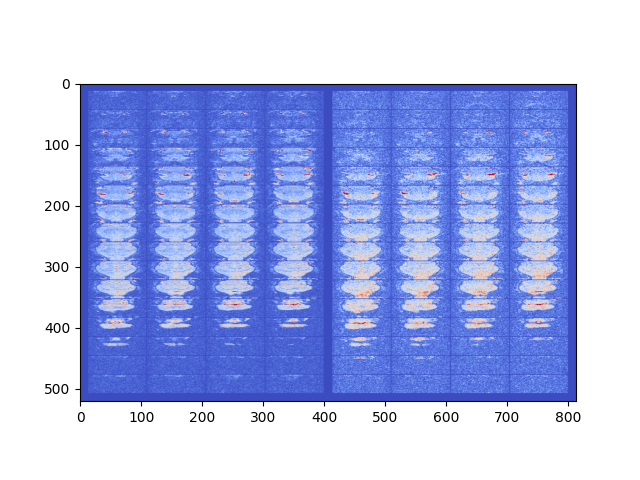

In [18]:
# import   .pyplot as plt
import matplotlib.pyplot as plt

%matplotlib widget

fig2 = plt.figure()
cmap = plt.get_cmap("coolwarm")
# 创建归一化器，将数据值映射到 [0, 1]
# norm = mcolors.Normalize(vmin=min_val, vmax=max_val)

# 将数据值通过归一化器和颜色映射转换为 RGBA 颜色
# cmap(norm(data)) 会返回一个 (Z, Y, X, 4) 的数组
# r = flatten_voxels_to_image(d[0], 4)
# r = d[0, 12]
# for i in range(12):
r = jax.vmap(flatten_voxels_to_image_with_borders, in_axes=(0, None, None, None))(
    d[0:2], 4, 1, 0
)
r = flatten_voxels_to_image_with_borders(r, grid_cols=2, border_width=12, border_value=0)
# facecolors = r / 1000
facecolors = cmap(
    (r - r.min())
    / (r.max() - r.min())
    # r.clip(-5000, 5000)
    # / 5000
    # / 1000.0
)  # 这里假设 d 是一个 (Z, Y, X) 的数组
# facecolors = cmap(
#     (r - r.min()) / (r.max() - r.min())
#     # r
# )  # 这里假设 d 是一个 (Z, Y, X) 的数组

# 可选：设置透明度 (修改 alpha 通道)
# facecolors[:, :, :, -1] = 0.7  # 设置所有体素的 alpha 值

# r = d[0].reshape((-1,))
# 使用 voxels 绘制
# 第一个参数是一个布尔数组，指示哪些体素需要绘制，这里我们绘制所有
# facecolors 参数指定每个体素表面的颜色
# edgecolors 可以设置边框颜色
ax2 = fig2.add_subplot()
ax2.imshow(facecolors)
# voxels = ax2.voxels(
#     jnp.ones(r.shape, dtype=bool),
#     facecolors=facecolors,
#     edgecolors="k",
#     linewidth=0.2,
# )
# facecolors